# Lab: Reusing a Model
Here we are going to load a previously trained model and use it 

### Runtime
15 minutes



In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
print ('tensorflow version :', tf.__version__)
tf.config.experimental.list_physical_devices()

tensorflow version : 2.2.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

## TF-GPU Debug
The following block tests if TF is running on GPU.

In [2]:
## This block is to tweak TF running on GPU
## You may comment this out, if you are not using GPU

## ---- start Memory setting ----
## Ask TF not to allocate all GPU memory at once.. allocate as needed
## Without this the execution will fail with "failed to initialize algorithm" error

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)
## ---- end Memory setting ----

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



## Step 1: Download Data

We have 2 datasets
- cat-dog-redux (smaller) (files: 1000 , size: ~25 MB )
- cat-dog-filtered (larger) (files: 3000,   size:~64 MB)

We will start with the smaller one.  
And once we have the full notebook ready, we can switch to the larger dataset.

In [3]:
# ## Smaller dataset

import os

data_location = 'https://elephantscale-public.s3.amazonaws.com/data/images/cat-dog-redux.zip'

data_location_local = keras.utils.get_file(fname=os.path.basename(data_location),
                                           origin=data_location, extract=True)
print ('local download file: ', data_location_local)
data_dir = os.path.join(os.path.dirname(data_location_local), 'cat-dog-redux')
print ('local data dir: ', data_dir)
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
print ('train dir:', train_dir)
print ('validation dir:', validation_dir)


local download file:  /home/sujee/.keras/datasets/cat-dog-redux.zip
local data dir:  /home/sujee/.keras/datasets/cat-dog-redux
train dir: /home/sujee/.keras/datasets/cat-dog-redux/train
validation dir: /home/sujee/.keras/datasets/cat-dog-redux/val


## Step 2: Define some constants

In [4]:
BATCH_SIZE=32
IMG_HEIGHT = 150
IMG_WIDTH = 150


## Step 3 : Prepare a Image Generator

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(rescale=1./255) # Generator for our validation data

data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              # class_mode='binary'
                                                              class_mode='categorical'
                                                             )

Found 500 images belonging to 2 classes.


## Step 4: Load the saved model

In [6]:
from tensorflow.keras.models import load_model
import os

model_file = 'cat-dog-model.h5'
model_size_in_bytes = os.path.getsize(model_file)


model = load_model(model_file)

print ("Loaded model '{}',  size = {} bytes / {:,.1f} KB  / {:,.1f} MB".format(model_file, 
                                    model_size_in_bytes, model_size_in_bytes / 1024, 
                                    model_size_in_bytes / (1024*1024) ))



Loaded model 'cat-dog-model.h5',  size = 85189024 bytes / 83,192.4 KB  / 81.2 MB


## Step 5: Predict

### 5.1 Predict on all images
Here is how we run prediction on all images in one shot!

In [7]:
%%time 

import numpy as np
from math import ceil


print ("predicting on {:,} test images".format(data_gen.n))
# we need a ceiling for steps
predictions = model.predict(data_gen, batch_size=data_gen.batch_size, 
                            steps=ceil(data_gen.n / data_gen.batch_size) )
print( 'predictions.shape: ', predictions.shape)
predictions2 = [ np.argmax(p) for p in predictions]

# ## Ensure all predictions match
assert(len(predictions) == len(predictions2) == len(data_gen.classes) )

predicting on 500 test images
predictions.shape:  (500, 2)
CPU times: user 1.66 s, sys: 260 ms, total: 1.92 s
Wall time: 1.86 s


### 5.2 - Predict on a Single Image
Sometimes we just want to predict on certain images.  
Here is how.  
Note how we are loading images and shaping the image

label mappings:  {'cat': 0, 'dog': 1}
image file:  /home/sujee/.keras/datasets/cat-dog-redux/val/cat/cat.7088.jpg
softmax output:  [[0.8497984 0.1502016]]
predicted class:  0 , probability: 0.8497984


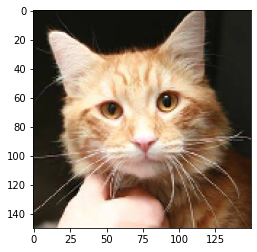

In [8]:
## Every time you run this cell, we will process a random image

import random
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# print ("image directory: ", data_gen.directory)
print ("label mappings: ", data_gen.class_indices)

index = random.randint(0, data_gen.n-1)

image_file = data_gen.filepaths[index]
print ("image file: ", image_file)
img = image.load_img(image_file, target_size = (IMG_WIDTH, IMG_HEIGHT))

# scale the data
img_data = image.img_to_array(img) / 255.0

## we need to shape the date to match the input shape network is expecting
# option 1 reshape
#img_data = np.expand_dims(img_data, axis = 0)
#prediction = model.predict (image_data)
# or option 2: no reshape and predict
prediction = model.predict(img_data[None]) # this is softmax output
print ('softmax output: ', prediction)

index_of_highest_probability = np.argmax(prediction[0])
value_of_highest_probability = prediction[0][index_of_highest_probability]

print ("predicted class: ", index_of_highest_probability, ", probability:", value_of_highest_probability)

## plot the image
plt.imshow(img_data)

### 5.3 - Visualizing Predictions

image directory:  /home/sujee/.keras/datasets/cat-dog-redux/val
label mappings:  {'cat': 0, 'dog': 1}


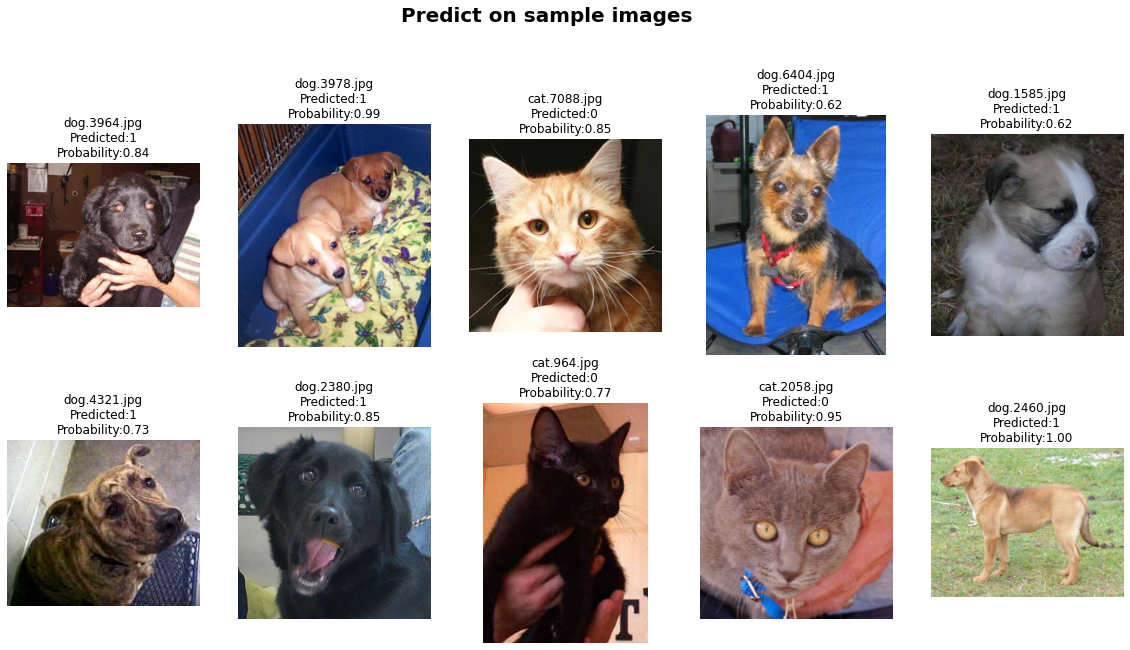

In [9]:
from image_utils import predict_on_images, plot_image_predictions
import random
import pprint

np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

print ("image directory: ", data_gen.directory)
print ("label mappings: ", data_gen.class_indices)
random_images = random.sample (data_gen.filepaths, 10)

prediction_results = predict_on_images(model, random_images, IMG_WIDTH, IMG_HEIGHT)
# pprint.pprint (prediction_results)

plot_image_predictions(prediction_results, "Predict on sample images")

## Step 6: Use your own images

This example shows how to predict on images, that are not segmented intro training/validation sets.  
These are mixed images, all in one directory

- we have some sample images that were not part of the cat/dog dataset in `my-images` directory
- Download some cat/dog pictures and put them into a directory called `my-images`
- And the following code will predict on them
- For fun, also include pictures of non cat-dog (like human or horse) and see what happens :-) 

Here are some websites that offer free images:
- https://www.pexels.com/
- https://pixabay.com/

label mappings:  {'cat': 0, 'dog': 1}


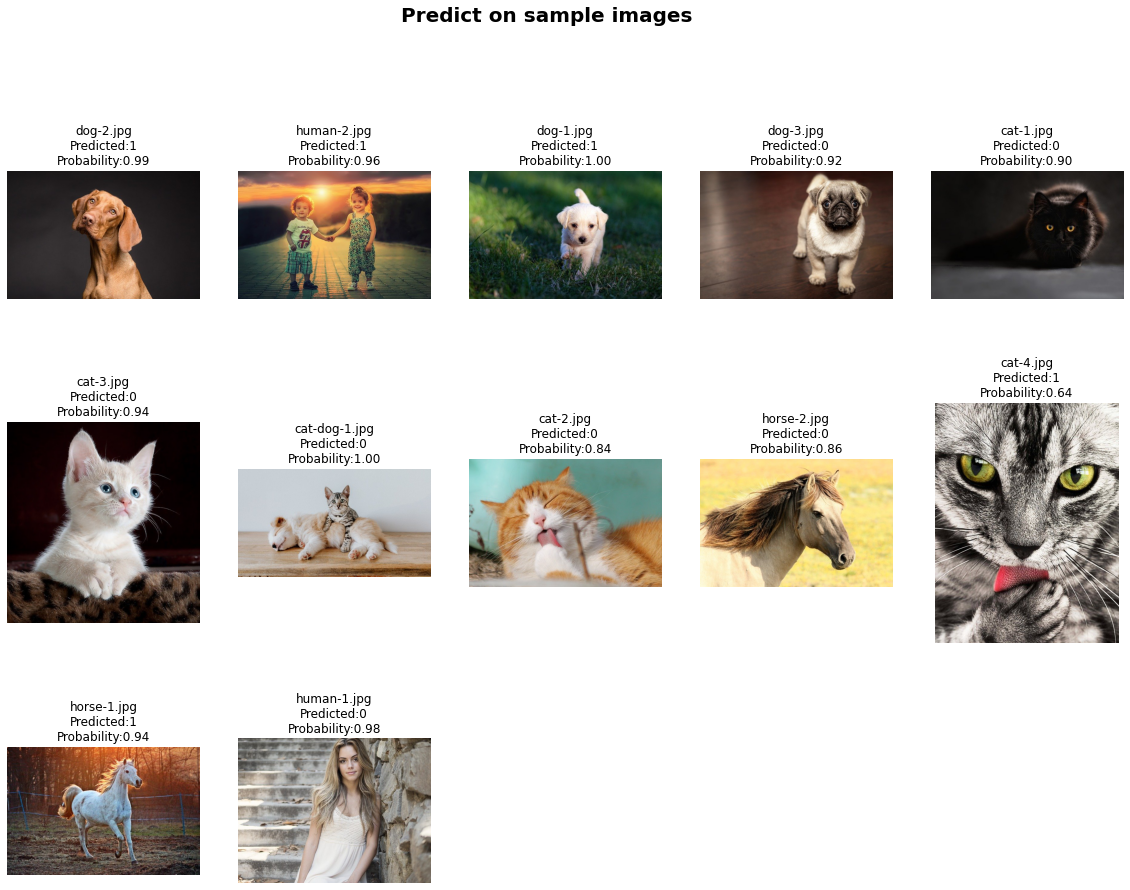

In [21]:
import os, glob
from image_utils import predict_on_images, plot_image_predictions
import pprint

listing = glob.glob('my-images/*.*')
image_files = [f for f in listing if os.path.isfile(f)]
# print (image_files)

np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

print ("label mappings: ", data_gen.class_indices)

prediction_results = predict_on_images(model, image_files, IMG_WIDTH, IMG_HEIGHT)
# pprint.pprint (prediction_results)

plot_image_predictions(prediction_results, "Predict on sample images")